# Time Series Anomaly Detection Lab
In this lab we will train a machine learning (ML) model that will have capability to detect anomalies in time series data.

- `Timeseries data` is a sequence of numbers with time stamps. Examples are temperature measurements taken every 10 seconds, or CPU utilization measured every minute.
- `Anomaly` is a specific time series behavior that does not seem right in general, or in the given context. For instance, single-core CPU utilization above 100% can be considered as anomalous measurement. Another example would be unexpectedly high GPU utilization given small number of job requests (e.g., machine learning inferences) - this might be an indication of some third-party unauthorized workload running on that GPU (e.g., crypto miner).

There are many ways to describe anomaly detection models - parametric and non-parametric; statistical, machine learning and deep learning based models, rule-based models etc. In particular:

- `Parametric models` make hard assumptions about probability distribution of input metric. For instance, z-score based method requires that input metric is distributed according to normal (Gaussian) distribution. Under this assumption, any value that is too far away from the mean of this distribution (let's say, 3 standard deviations away) is considered to be anomalous. An example of such a metric could be the length of manufactured bolts that are all supposed to be the same length.
- `Non-parametric models` do not assume anything about probability distribution of input metrics. Statistical methods such as interquartile range (IQR) and mean absolute deviation (MAD) are simple examples of statistical approaches that can be used for anomaly detection.

No matter what method is used, a common approach is to assume that we have a `model` of a data. That can be model of a data generation process (bolts manufacturing example above), or a statistical or machine learning model that describes or explains nominal behavior or corresponding metrics. Then, any metric values that are not consistent with such models are considered to be anomalous.

In this lab, we will be using a deep learning based approach to anomaly detection. In particular, we will train a special neural network called a fully-connected autoencoder. An autoencoder is a model that learns to reconstruct its inputs. It is composed of two components. The first component called encoder. It converts input data into (usually) a lower-dimensional representation that is called a latent representation, or a hidden representation, or just a code. Then, the second component called a decoder tries to reconstruct input using this compressed, lower-dimensional, code. Assumption is that any input that can be reconstructed by the model with small error (measured, for instance, as mean squared error) is considered to be nominal. Large reconstruction errors suggest that input data might be anomalous. Why is it? It's because we assume anomalies are rear. And so, training datasets either do not contain examples of anomalous behavior, or number of such examples is small that do not impact the training process. Having assumed that, we then think about trained ML models as models of nominal behavior that won't accept anomalous data (in some way or another, depending on a particular model type).

## Anomaly Detection ML pipeline
We will build the ML pipeline that will consist of the following steps:
1. `Ingest` step will ingest our dataset into our ML pipeline, so that it becomes available to all other steps.
2. `Split` step will split the dataset into training, evaluation, testing and threshold selection datasets.
3. `Transform` step will standardize time series so that it has zero mean and unit standard deviation, a step required for many ML algorithms.
4. `Create datasets` step will create datasets suitable to train ML anomaly detection models.
5. `Train baseline model` will train a very simple model. We will use its accuracy to decide if our model makes sense.
6. `Train autoencoder model` will train a neural-network based autoencoder that will serve as a model of our data.
7. `Approve` step will compare accuracy of a baseline model with the accuracy of our autoencoder model. In latter is better, a model will be considered approved for use for anomaly detection.
8. `Calibrate anomaly detection model` will add additional processing components on top of autoencoder that will turn this model into an anomaly detection model.
9. `Perform final test` on a test dataset, and visualize results of anomaly detection model.


> This Lab needs python version >= 3.8

## Prerequisites

In [1]:
# Import python dependencies
import sys
import typing as t
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.dummy import DummyRegressor
from dataclasses import dataclass

print(f"python={sys.version}, numpy={np.__version__}, pandas={pd.__version__}, tensorflow={tf.__version__}")

2023-02-14 10:50:49.731187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 10:50:49.919099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 10:50:49.919156: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 10:50:50.830272: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

python=3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0], numpy=1.24.1, pandas=1.5.3, tensorflow=2.11.0


In [2]:
# Define helper functions.

def mse_loss(expected: np.ndarray, actual: np.ndarray, average: bool = True) -> t.Union[float, np.ndarray]:
    """ Compute Mean Squared Error loss given two tensors (n-dimensional arrays).
    Args:
        expected: 2-rank tensor (matrix) of shape [NumExamples, NumOutputs]. When model is a
                  reconstruction model, `expected` equals to model's inputs.
        actual: 2-rank tensor (matrix) of shape [NumExamples, NumOutputs].
        average: if True, average across all examples.

    In this Lab, mean squared error (mse) is a synonym to `anomaly score`. Indeed, mse is always positive and
    for any two inputs with mse values `mse_1` and `mse_2`, `mse1` < `mse2` implies that pattern 1 is less
    anomalous than pattern 2.
    """
    mse: np.ndarray = np.mean((actual - expected) ** 2, axis=1)
    if average:
        return np.mean(mse).item()
    return mse.reshape(-1, 1)


anomaly_score = mse_loss


@dataclass
class Model:
    """A class that represents anomaly detection model with its training and evaluation loss."""
    model: t.Any
    """Actual anomaly detection model."""

    train_loss: t.Optional[float] = None
    """Model training loss."""

    eval_loss: t.Optional[float] = None
    """Model evaluation loss."""

## 1. Ingest
We will use one of CDU (Coolant Distribution Unit) metric from NREL (National Renewable Energy Lab). This CDU is part of HPE's Eagle supercomputer.

> The dataset used in the Lab is a synthetic dataset. It was constructed in the following way. Actual dataset was used to train two models (based on N-grams - an approach to build language models in natural language processing domain). One model is for nominal data, and one model is for anomalous data. Then, these models were used to generate synthetic metric values for nominal and anomalous regimes.

In [3]:
# Load metric ('ValveDemand') from a compressed CSV file. This file contains only two columns - time stamps
# and metric. We'll convert the time stamp column into time index. As a result, the data frame will contain
# just one column - ValveDemand metric.
df: pd.DataFrame = pd.read_csv('./valve_demand_synthetic_07.csv.gz', index_col='Timestamp', parse_dates=True)
print(f'Data frame contains the following columns: {list(df.columns)}. Index type is {df.index.dtype}.')

Data frame contains the following columns: ['ValveDemand']. Index type is datetime64[ns].


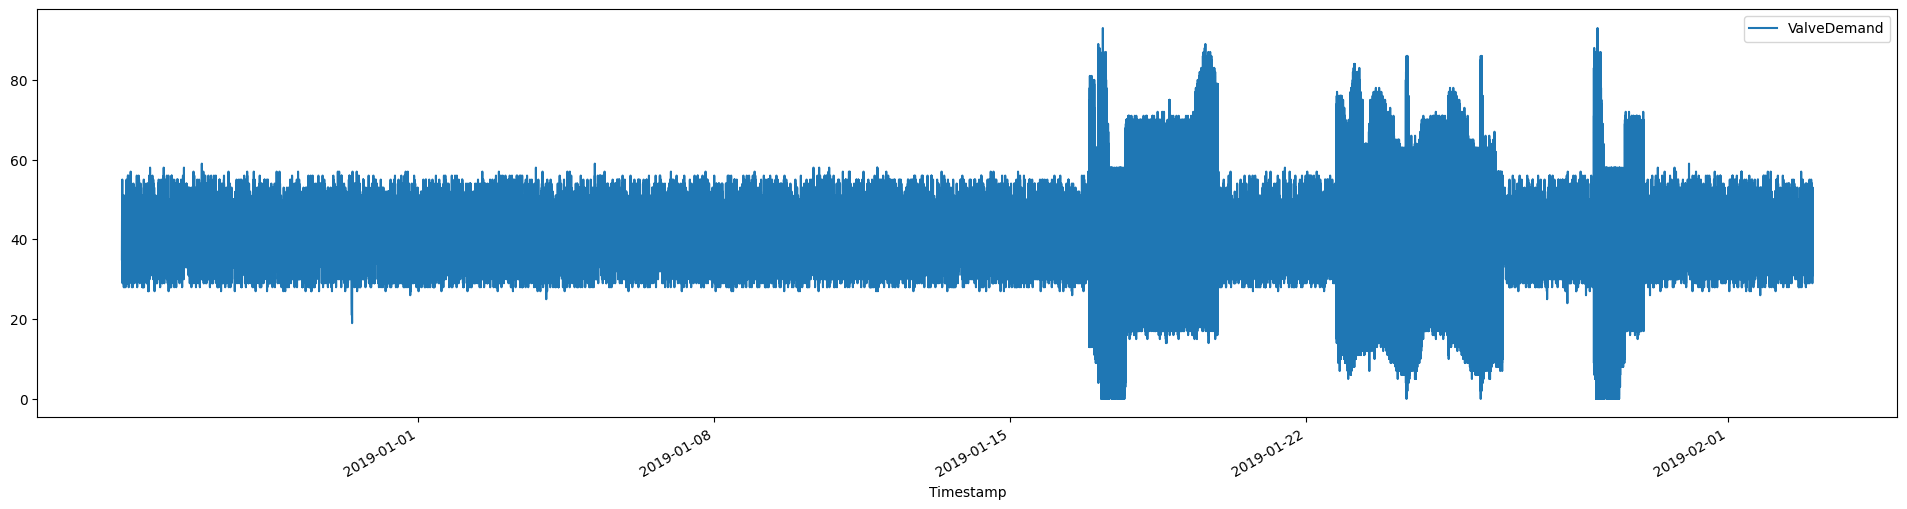

In [4]:
_ = df.plot(figsize=(24, 6))

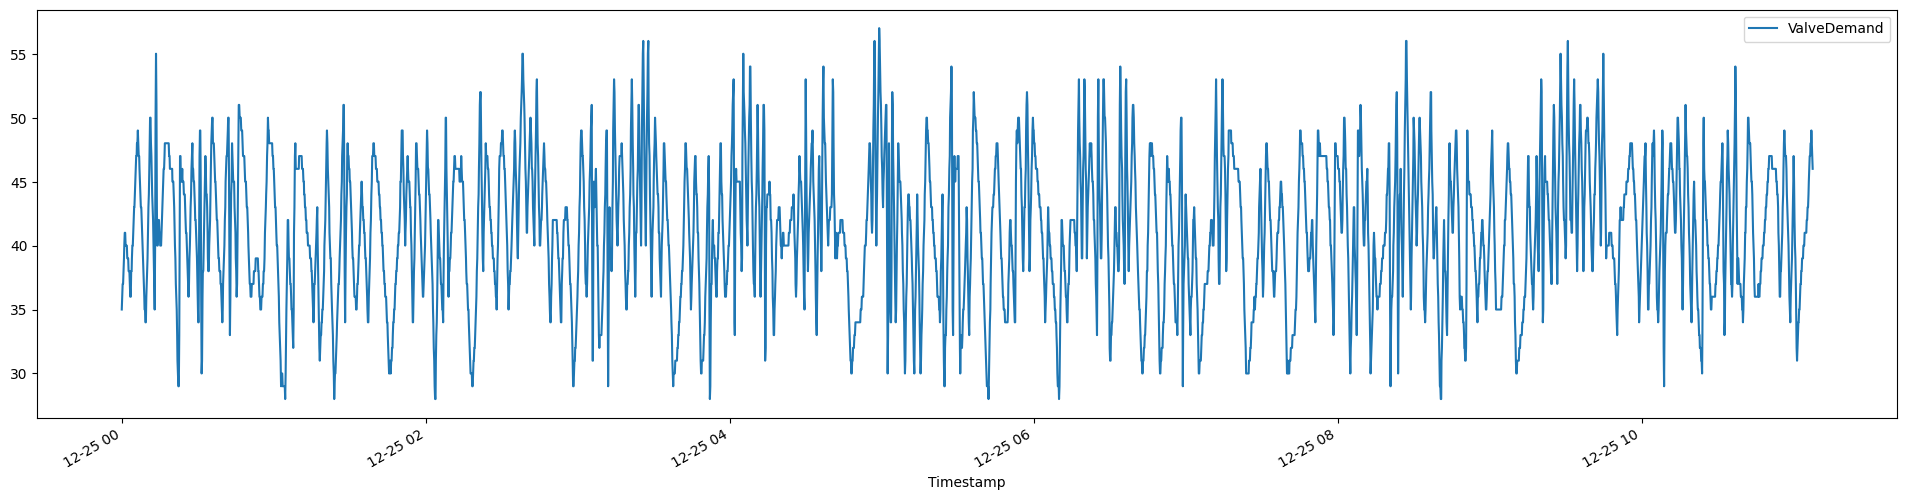

In [5]:
# Let's look at metric at a different scale.
_ = df.iloc[0:4000,].plot(figsize=(24, 6))

Every Coolant Distribution Unit in the data center is supposed to support 1 cooling tower and 4 IT racks. However, one of the CDUs had to support only two IT racks which is half the regular load. PID controller installed in the CDU was configured for full load but had to operate in different settings. So, as a result, the valve in this CDU  was demonstrating cycling behavior which you can see in this figure - three regions in right part demonstrate bigger amplitude compared to expected (nominal) behavior shown in the left part of the figure.

# 2. Split
In ML field, there's a rule of thumb that says that we should use one chunk of data (also known as split) for one purpose. Train on one subset of your data, test on a different subset of your data. There are many reasons for doing so, the most important one being that using one split will result in a model that can over fit to your data. The goal is not to train an ML model that has minimal error on train dataset, but have a model that generalizes well on unseen data. Having an independent dataset that we use to evaluate our model results in more realistic estimations of what performance our model will have once deployed.

Given we have enough data, a simple approach would be to randomly select a subset of data points for testing, evaluation and other datasets. With time series it's a little different. We can't use this approach, because this will result in a so-called `information leakage`. Look at the figure above. Imagine we train our ML model on randomly selected data points. This can and will result in a situation, where a model uses data from the future to operate on data from the past (that will be part of our test dataset). This results in the fact that our reported final performance will be overestimated.

To avoid this, we need to use a special, but relatively simple, approach to build various subsets of data:

1. `Train` split will be used for training ML model.
2. `Eval` split will be used to evaluate a model in the training process. This is known as early stopping. Our final model will be the model with the best performance on this eval split.
3. `Threshold selection` split will be used to calibrate anomaly detection model. More on this later in this Lab.
4. `Test` split will be the subset we are going to be using for final model testing. Reported model accuracy is the one obtained on this split.

We will use first part of the time series as our train split, then goes eval split, followed by threshold selection adn test splits. The following dictionary defines split names and their corresponding time ranges. Pay attention that these splits do not intersect and follow in this particular order.

In [6]:
split_config = dict(
    train=['2018-12-25', '2019-02-03'],
    eval=['2018-12-25', '2019-01-05'],
    threshold_selection=['2019-01-09', '2019-01-14'],
    test=['2019-01-14', '2019-02-03']
)

In [7]:
# Split input raw data into multiple splits.
datasets = {}
for name, dates in split_config.items():
    datasets[name] = df[(df.index >= dates[0]) & (df.index < dates[1])]

pd.DataFrame([dict(name=n, begin=d.index[0], end=d.index[-1], size=len(d)) for n, d in datasets.items()])

,name,begin,end,size
0,train,2018-12-25 00:00:01.994,2019-02-02 23:59:54.588,345432
1,eval,2018-12-25 00:00:01.994,2019-01-04 23:59:55.083,94962
2,threshold_selection,2019-01-09 00:00:02.528,2019-01-13 23:59:55.366,43192
3,test,2019-01-14 00:00:01.873,2019-02-02 23:59:54.588,172727


## 3. Transform
Some ML models require inputs to be preprocessed - normalized, standardized etc. We need to do so to ensure that magnitude of our model inputs are roughly the same. We will use a standardization technique that will ensure that our dataset has zero mean and unit standard deviation. We will use train split to compute standardization parameters (mean and standard deviation), and will use these parameters to preprocess all other dataset splits.

In [8]:
# Compute standardization parameters
mean, std = datasets['train'].mean().item(), datasets['train'].std().item()
print(f"[Train Split] mean={mean}, standard deviation={std}")

# Transform dataset
transform_info = []
for split in datasets.keys():
    transform_info.append(dict(name=split, orig_mean=datasets[split].mean().item(), orig_std=datasets[split].std().item()))
    datasets[split] = (datasets[split] - mean) / std
    transform_info[-1].update(dict(new_mean=datasets[split].mean().item(), new_std=datasets[split].std().item()))

pd.DataFrame(transform_info)

[Train Split] mean=40.9913818059705, standard deviation=10.279118239758969


,name,orig_mean,orig_std,new_mean,new_std
0,train,40.991382,10.279118,-2.909582e-16,1.000000
1,eval,41.071123,5.353334,7.757609e-03,0.520797
2,threshold_selection,41.231640,5.372933,2.337344e-02,0.522704
3,test,40.830142,13.512696,-1.568612e-02,1.314577


## 4. Create datasets
At this moment, we have multiple time series - train, eval, threshold selection and test splits. Our models in this Lab will be `reconstruction-based models`. These models reconstruct their inputs X, and they output Y so that Y is as close to X as possible. We assume this reconstruction is non-trivial, so we expect the residual term Y-X to be a non-zero value.

So, we need to convert time series into ML datasets that can be consumed by ML models. A common method is to use a sliding window approach. A sliding window has certain length N, where N is the number of time series data points this window includes at any given moment in time. We'll consider these N numbers as inputs to our model. Then, this window makes a step skipping K points. The number - K - is called a `stride`, and we'll be using a stride of 1 in this Lab.


Imagine, we have the following time series - sequence of numbers. Let's assume that we want our model to use 4 time series values. This means N (window size) is 4.
```
1 2 3 4 5 6 7 8
```

By applying the sliding window transformation to the above time series with window length equal to 4 and stride equal to 1, we obtain the following dataset:
```
1 2 3 4
2 3 4 5
3 4 5 6
4 5 6 7
5 6 7 8
```

As it can be seen, number of examples in this ML dataset is `N - window_size + 1`.

In [9]:
# Window size, or number of inputs (features) to our ML models.
num_features = 32

def _make_ml_dataset(_df: pd.DataFrame, _window_size: int = 16) -> np.ndarray:
    """ Helper function to convert a sequence of numbers (time series) into multiple ML examples.

    Args:
        _df: Input metric (pandas data frame with exactly one column - metric). We assume
            that this metric is continuous (there are no gaps).
        _window_size: Size of a moving window. Stride is fixed to 1 in this implementation.

    Returns:
        A 2D numpy array of shape [NumExamples, _window_size]
    """
    _ds: np.ndarray = _df.iloc[:, 0].values.reshape(-1, 1)
    return np.hstack([
        _ds[i:1 + i - _window_size or None:1] for i in range(0, _window_size)
    ])

# Convert all data splits (time series) into ML datasets.
for split in datasets.keys():
    datasets[split] = _make_ml_dataset(datasets[split], num_features)
    print(f"Split={split}, shape={datasets[split].shape}")

Split=train, shape=(345401, 32)
Split=eval, shape=(94931, 32)
Split=threshold_selection, shape=(43161, 32)
Split=test, shape=(172696, 32)


## 5. Baseline model
This baseline model will establish the lower bound for performance. If actual model's performance is worse than performance of this baseline model, we'll consider this as a failure to train a model. We'll use DummyRegressor model from scikit learn library.


In [10]:
# Dummy regressor always outputs constant value for any possible input. We'll use mean of the training dataset for this.
baseline = Model(
    model=DummyRegressor(strategy='mean').fit(datasets['train'], datasets['train'])
)
baseline.train_loss = mse_loss(
    datasets['train'],
    baseline.model.predict(datasets['train']),
    average=True
)
baseline.eval_loss = mse_loss(
    datasets['eval'],
    baseline.model.predict(datasets['eval']),
    average=True
)
print(f"[BaselineModel] train_loss={baseline.train_loss}, eval_loss={baseline.eval_loss}")

[BaselineModel] train_loss=1.0000648518543311, eval_loss=0.2713328411412918


## 6. Training an autoencoder model

In [11]:
class AutoencoderModel(object):
    """Implementation of an autoencoder - a neural network that reconstructs its inputs, and is used in many DL problems."""
    def __init__(self, input_dim: int, latent_dim: int) -> None:
        """"
        Args:
            input_dim: Number of inputs (and outputs) of this model.
            latent_dim: Dimensionality of a latent space. Usually, it's much smaller compared to `input_dim`.
        """
        self.model: t.Optional[tf.keras.Model] = None    # TensorFlow model.
        self.input_dim = input_dim                       # Number of inputs (same as number of outputs).
        self.latent_dim = latent_dim                     # Size of latent space.
        self.history = None                              # Training history object.
        assert (input_dim > latent_dim > 0) and \
               (input_dim & (input_dim - 1) == 0) and \
               (latent_dim & (latent_dim - 1) == 0), f"Input dimension ({input_dim}) must be bigger than latent "\
                                                     f"dimension ({latent_dim}), and both values must be power of two."

    def _create_model(self) -> tf.keras.Model:
        """Create an Autoencoder model.

        Returns:
            Sequential Keras model - fully-connected autoencoder. The encoder and decoder components are symmetrical
            in this model. Each component will have M layers that depends on input and latent dimensionalities - each
            layer decreases (encoder) or decreases (decoder) its size by a factor of two compared to previous layer.
            This is an example architecture with 8 inputs and 2-dimensional latent space:

          Input X    Code    Output Y
            *                   *
            *                   *
            *    *         *    *
            *    *    *    *    *
            *    *    *    *    *
            *    *         *    *
            *                   *
            *                   *
            <-------->|<-------->
              encoder   decoder
        """
        model = tf.keras.Sequential()
        dim: int = self.input_dim // 2
        while dim >= self.latent_dim:
            model.add(tf.keras.layers.Dense(dim, activation='relu'))
            dim = dim // 2
        dim = self.latent_dim * 2
        while dim <= self.input_dim:
            model.add(tf.keras.layers.Dense(dim, activation='linear' if dim == self.input_dim else 'relu'))
            dim = dim * 2
        return model

    def fit(self, _datasets: t.Dict) -> 'AutoencoderModel':
        """Train a neural network"""
        self.model = self._create_model()                                                # Create model.
        self.model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())    # Compile and provide info for optimization process.

        # Train this model - 5 epochs seems to be enough.
        self.history = self.model.fit(
            _datasets['train'],
            _datasets['train'],
            validation_data=(_datasets['eval'], _datasets['eval']),
            epochs=5,
            shuffle=True
        )
        return self

    def predict(self, inputs: np.ndarray) -> np.ndarray:
        return self.model.predict(inputs)

In [12]:
# Create a model and compute mean squared error losses for train and evaluation datasets.
autoencoder = Model(
    model=AutoencoderModel(input_dim=num_features, latent_dim=2).fit(datasets)
)
autoencoder.train_loss = mse_loss(
    datasets['train'],
    autoencoder.model.predict(datasets['train'])
)
autoencoder.eval_loss = mse_loss(
    datasets['eval'],
    autoencoder.model.predict(datasets['eval'])
)
print(f"[AutoencoderModel] train_loss={autoencoder.train_loss}, eval_loss={autoencoder.eval_loss}")

2023-02-14 10:50:56.935785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-14 10:50:56.935826: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-14 10:50:56.935861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-3): /proc/driver/nvidia/version does not exist
2023-02-14 10:50:56.936166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
10794/10794 [==============================] - 26s 2ms/step - loss: 0.4070 - val_loss: 0.1262
Epoch 2/5
10794/10794 [==============================] - 25s 2ms/step - loss: 0.3378 - val_loss: 0.1258
Epoch 3/5
10794/10794 [==============================] - 26s 2ms/step - loss: 0.3246 - val_loss: 0.1252
Epoch 4/5
10794/10794 [==============================] - 23s 2ms/step - loss: 0.3048 - val_loss: 0.1270
Epoch 5/5
2967/2967 [==============================] - 4s 1ms/step
[AutoencoderModel] train_loss=0.2814619789040836, eval_loss=0.12511275624324059


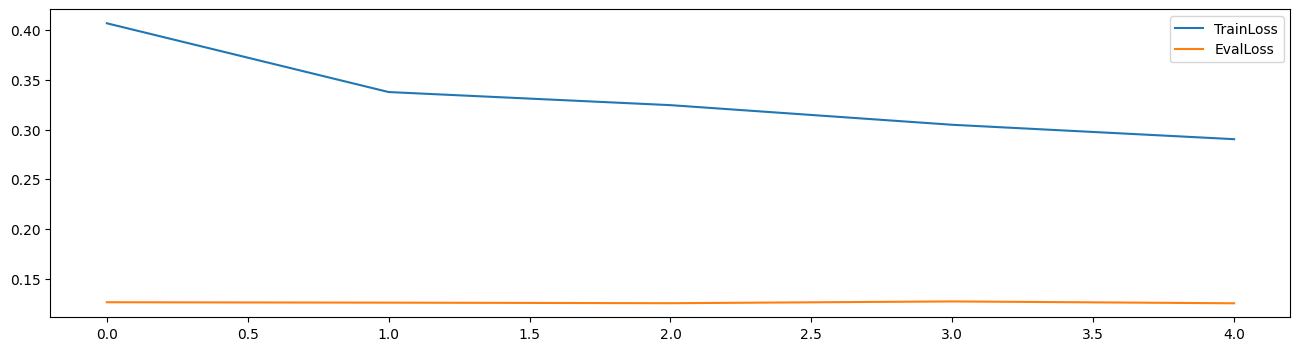

In [13]:
# Visualize training history. Normally, you want to use some ML experiment tracking tools, such as
# MFlow, Aim, Weights and Biases etc. to do this (manage your ML experiments).
_ = pd.DataFrame(
    dict(
        TrainLoss=autoencoder.model.history.history['loss'],
        EvalLoss=autoencoder.model.history.history['val_loss']
    )
).plot(figsize=(16, 4))

## 7. Approve
We have trained two models. Here, we approve our main model (autoencoder) if its loss is smaller than the loss of the baseline model. It's not always possible to say if model's accuracy is good enough, this especially applies to regression models. We use baseline model's performance as a lower bound for our model.

In [14]:
if autoencoder.eval_loss <= baseline.eval_loss:
    print("[APPROVED]     Autoencoder model is better than the baseline model.")
else:
    print("[NOT APPROVED] Autoencoder model is worse than the baseline model.")

[APPROVED]     Autoencoder model is better than the baseline model.


## 8. Calibrate Anomaly Detection Model
We have trained an autoencoder - a model that uses a sequence of non-linear functions to embed inputs into a (usually) lower-dimensional space. This space is called a hidden or latent space. Then, this model uses this latent representation to reconstruct the original input pattern. We call this neural network (autoencoder) as model of our data. We assume that training dataset mostly contains nominal data, and autoencoder learns to reconstruct nominal inputs. Small reconstruction errors indicate that input is nominal, while large reconstruction errors indicate that input is most likely abnormal, since such examples have not been present in the training dataset.

Model calibration is basically the process of selecting a decision threshold for anomaly scores. If anomaly score is above this threshold, input is declared to be anomalous. There are many approaches to compute it, and in this Lab we'll use the simplest one that uses n-th percentile as this threshold. We'll use 99th percentile. In some open source libraries, such as alibi-detect, this percentile is referred to as a contamination factor, and is the default (maybe the only one) algorithm to estimate thresholds.

> Actually, contamination factor is computed as  `1.0 - percentile / 100`, e.g. for 99th percentile the contamination factor would be 0.01.

In [15]:
# Compute example-wise reconstruction errors on a special dataset split (threshold_selection).
losses: np.ndarray = mse_loss(
    datasets['threshold_selection'],
    autoencoder.model.predict(datasets['threshold_selection']),
    average=False
)
# Compute threshold as 99th percentile
threshold = np.percentile(losses.flatten(), q=99).item()
print(f"Threshold = {threshold}")

1349/1349 [==============================] - 2s 1ms/step
Threshold = 0.3378702899196974


## 9. Perform final tests

In [16]:
# Apply model to test dataset.
test_inputs = datasets['test']                                             # Test dataset     .
test_outputs = autoencoder.model.predict(datasets['test'])                 # Model output for test dataset.
anomaly_scores = anomaly_score(test_inputs, test_outputs, average=False)   # Anomaly scores (mean squared errors).

# At this point, we have anomaly scores computed for each input. Since each input is a vector of size `num_features`
# representing a window, we compute one score (floating point number) for this window. We can use these scores as is,
# but since moving window step (stride) is 1 in this Lab, every time series data point gets `num_features` anomaly
# scores from multiple predictions. One way to deal with this is to compute average value. Below we do this:
average_scores = np.convolve(anomaly_scores.flatten(), np.ones(num_features), 'valid') / num_features

5397/5397 [==============================] - 8s 2ms/step


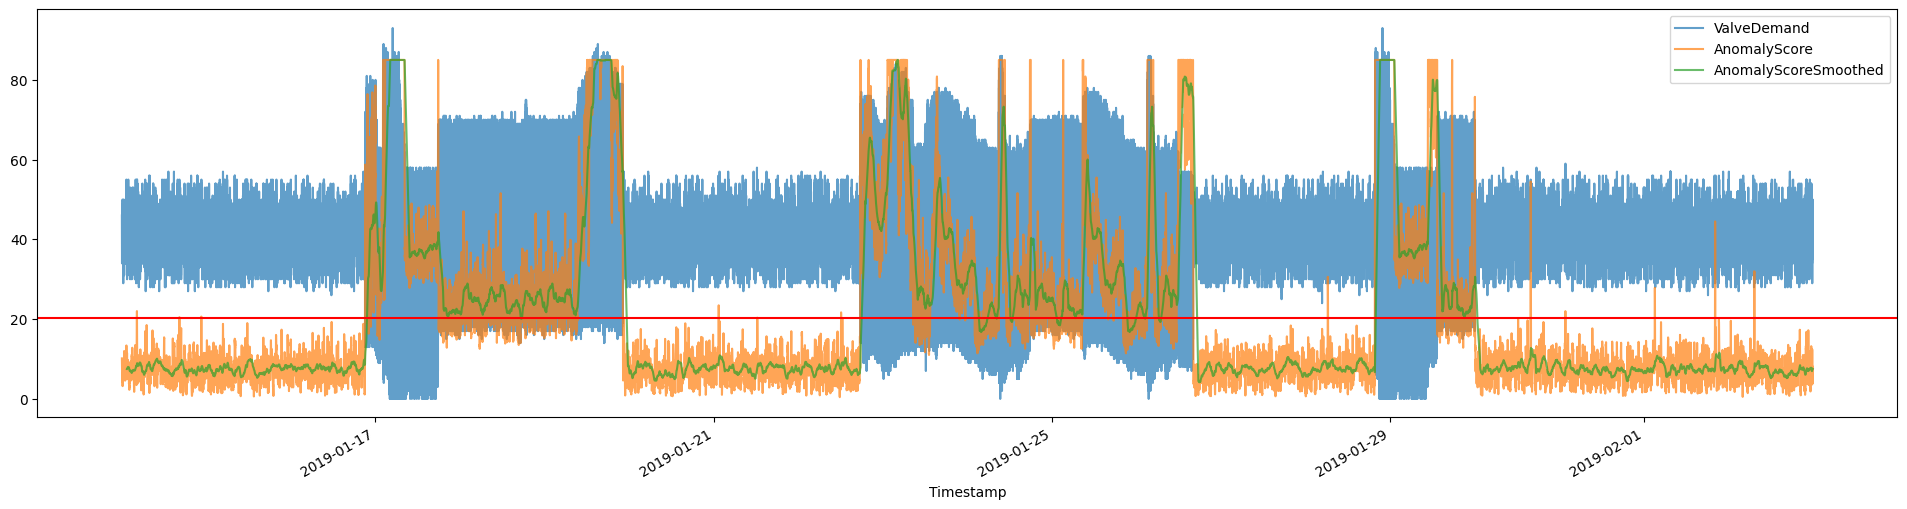

In [17]:
# Now, we will visualize the anomaly detection results for test dataset.
num_predictions = len(average_scores)      # Total number of predictions.
scale_factor = 60.0                        # To show input metric (ValveDemand) and anomaly scores
                                           # in one figure, we'll scale anomaly scores.

summary = pd.DataFrame(
    dict(
        # Input metric.
        ValveDemand=df.ValveDemand[-(num_features + num_predictions): -num_features],
        # Anomaly scores - we'll clip values to make figure look nicer.
        AnomalyScore=np.clip(average_scores * scale_factor, 0, 85)
    ),
    index=df.index[-(num_features + num_predictions): -num_features]
)
# It's always a good idea to do some post-processing for anomaly scores before using them in
# decision-making process. One option, a very simple one, is to smooth the series of anomaly
# scores. The number below (512) is pretty much random here, but can be tuned on a test dataset
# if labels (annotations) are available.
summary['AnomalyScoreSmoothed'] = summary['AnomalyScore'].rolling(512).mean()

axes = summary.plot(figsize=(24, 6), alpha=0.7)     # Plot metric and anomaly scores.
_ = axes.axhline(threshold * scale_factor, c='r')   # Plot anomaly detection threshold.

The training process is a stochastic proces. Each time we train a model, results above can be different (fixing random seeds in python/numpy/tensorflow can help with reproduciability, what is, by the way, a good practice). We also have not conducted search of the best hyperparameters. These are parameters like size of latent space, number of layers and types of non-linearities, parameters of optimizers (batch size, learning rate, momentum etc).